# Central Composite Design Example

Import necessary libraries:

In [2]:
import os
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt

Define some useful functions for translating back and forth between natural and coded units:

In [3]:
def convertNtoC(U, UH, UL):
    x = (U - (UH+UL)/2) / ((UH-UL)/2)  
    return x

def convertCtoN(x, UH, UL):
    U = x*(UH-UL)/2 + (UH+UL)/2
    return U

Change the working directory:

In [4]:
os.chdir("/Users/nstevens/Dropbox/Teaching/MSDS_629/2023/Lectures/Lecture8")

Read in the data and look at it:

In [5]:
lyft = pd.read_csv('lyft-ccd.csv')
lyft.head(10)

,x1,x2,y
0,-1.0,-1.0,1
1,-1.0,-1.0,1
2,-1.0,-1.0,1
3,-1.0,-1.0,1
4,-1.0,-1.0,1
5,-1.0,-1.0,1
6,-1.0,-1.0,1
7,-1.0,-1.0,1
8,-1.0,-1.0,1
9,-1.0,-1.0,1


The data correspond to a CCD on two factors with axial conditions based on $a = 1.4$. The loaded data is in coded units where the "low" and "high" values of each factor in natural units is as follows:

* $x_1$: Discount amount (%): 25 vs 75
* $x_2$: Discount duration (days): 2 vs 7

Let's add some columns to `lyft` that contain the factor levels in natural units. Let's also calculate the booking rate in each condition.

In [6]:
x1_N = convertCtoN(x=lyft['x1'], UH=75, UL=25)
x2_N = convertCtoN(x=lyft['x2'], UH=7, UL=2)
lyft['Discount'] = x1_N
lyft['Duration'] = x2_N
lyft.groupby(['Discount','Duration']).mean()

x1   x2     y
Discount Duration                
15.0     4.5      -1.4  0.0  0.50
25.0     2.0      -1.0 -1.0  0.71
         7.0      -1.0  1.0  0.32
50.0     1.0       0.0 -1.4  0.78
         4.5       0.0  0.0  0.72
         8.0       0.0  1.4  0.26
75.0     2.0       1.0 -1.0  0.71
         7.0       1.0  1.0  0.35
85.0     4.5       1.4  0.0  0.53

Next let us fit the full 2nd order model with linear predictor given by $$\beta_0+\beta_1x_1+\beta_2+x_2+\beta_{12}x_1x_2+\beta_{11}x_1^2+\beta_{22}x_2^2$$

In [7]:
model = smf.logit('y ~ x1 + x2 + x1:x2 + I(x1**2) + I(x2**2)', data = lyft).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.617399
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 4500
Model:                          Logit   Df Residuals:                     4494
Method:                           MLE   Df Model:                            5
Date:                Mon, 02 Jan 2023   Pseudo R-squ.:                  0.1047
Time:                        16:32:47   Log-Likelihood:                -2778.3
converged:                       True   LL-Null:                       -3103.1
Covariance Type:            nonrobust   LLR p-value:                3.849e-138
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9428      0.100      9.474      0.000       0.748       1.138
x1             0.0388      0.033      1.174      0.241      -0.026       0.104
x2            -0.8068      0.036    -22.612      0.000      -0.877      -0.737
x1:x2          0.0339      0.048      0.700      0.484      -0.061       0.129
I(x1 ** 2)    -0.4421      0.058     -7.637      0.000      -0.556      -0.329
I(x2 ** 2)    -0.4145      0.059     -6.989      0.000      -0.531      -0.298
==============================================================================
"""

Let's visualize this fitted surface:

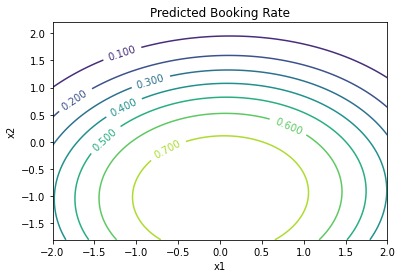

In [8]:
beta0 = model.params[0]
beta1 = model.params[1]
beta2 = model.params[2]
beta12 = model.params[3]
beta11 = model.params[4]
beta22 = model.params[5]
x1, x2 = np.meshgrid(np.linspace(convertNtoC(U = 0, UH = 75, UL = 25), 
                                 convertNtoC(U = 100, UH = 75, UL = 25), 100), 
                     np.linspace(convertNtoC(U = 0, UH = 7, UL = 2), 
                                 convertNtoC(U = 10, UH = 7, UL = 2), 100))
eta = beta0 + beta1*x1 + beta2*x2 + beta12*x1*x2 + beta11*x1**2 + beta22*x2**2
pi = np.exp(eta)/(1+np.exp(eta))
h = plt.contour(x1, x2, pi)
plt.clabel(h, inline=True, fontsize=10)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Predicted Booking Rate')
plt.show()

Now in natural units:

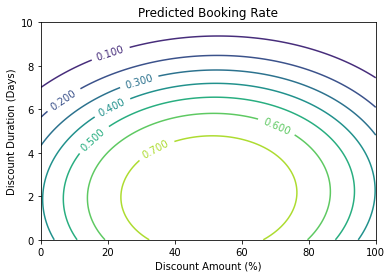

In [9]:
h = plt.contour(convertCtoN(x1, UH=75, UL=25),
                convertCtoN(x2, UH=7, UL=2), pi)
plt.clabel(h, inline=True, fontsize=10)
plt.xlabel('Discount Amount (%)')
plt.ylabel('Discount Duration (Days)')
plt.title('Predicted Booking Rate')
plt.show()

Let's find the maximum of this surface and the corresponding factor levels at which this is achieved

In [10]:
b = np.matrix([beta1, beta2]).transpose()
B = np.matrix([[beta11, 0.5*beta12], [0.5*beta12, beta22]])
x_s = -0.5* np.matmul(np.linalg.inv(B), b)
print("Booking rate is maximized when x1=", x_s[0], "and x2=", x_s[1])

Booking rate is maximized when x1= [[0.00656521]] and x2= [[-0.97304723]]


In natural units this optimum is located at:

In [11]:
xsN_1 = convertCtoN(x = x_s[0], UH = 75, UL = 25)
xsN_2 = convertCtoN(x = x_s[1], UH = 7, UL = 2)
print("Amount=", xsN_1, ", Duration=", xsN_2)

Amount= [[50.16413014]] , Duration= [[2.06738192]]


The predicted booking rate at this configuration is:

In [12]:
eta_s = beta0 + 0.5*np.matmul(x_s.transpose(), b)
print(np.exp(eta_s)/(1+np.exp(eta_s)))

[[0.79175174]]


The predicted booking rate at a convient configuration near the optimum (Amount = 50, Duration = 2) is:

In [13]:
yhat = model.predict(exog=dict(x1=convertNtoC(U = 50, UH = 75, UL = 25), 
                               x2=convertNtoC(U = 2, UH = 7, UL = 2)))
print(yhat)

0    0.7917
dtype: float64


This is a very similar prediction to what was observed at the _true_ optimum. So given the convenience of a 50\% discount for 2 days, we might recommend that discount as a _practical_ optimum for which we expect a booking rate of roughly 80\%.